In [1]:
import leafmap, geoai
from geoai.download import (
    download_naip,
    download_overture_buildings,
    extract_building_stats,
)

In [18]:
m = leafmap.Map(center=[47.6526, -117.5923], zoom=16)
m.add_basemap("Esri.WorldImagery")
m

Map(center=[47.6526, -117.5923], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [20]:
bbox = m.user_roi_bounds()
if bbox is None:
    bbox = (-117.6029, 47.65, -117.5936, 47.6563)

print("bbox:", bbox)

bbox: [-117.5955, 47.6514, -117.5946, 47.652]


In [4]:
items = geoai.pc_stac_search(
    collection="naip",
    bbox=bbox,
)
items

Found 7 items matching search criteria


[<Item id=wa_m_4711720_sw_11_060_20230701_20230911>,
 <Item id=wa_m_4711720_sw_11_060_20210627>,
 <Item id=wa_m_4711720_sw_11_060_20190726_20191217>,
 <Item id=wa_m_4711720_sw_11_1_20170717_20171128>,
 <Item id=wa_m_4711720_sw_11_1_20150702_20160104>,
 <Item id=wa_m_4711720_sw_11_1_20130628_20130820>,
 <Item id=wa_m_4711720_sw_11_1_20110702_20111004>]

In [5]:
# Download NAIP imagery for the specified region
downloaded_files = download_naip(
    bbox=bbox,
    output_dir="naip_data",
    max_items=1,
    year=2023,
)

print(f"Downloaded {len(downloaded_files)} files.")

Found 1 NAIP items.
Skipping existing file: naip_data/m_4711720_sw_11_060_20230701_20230911.tif
Downloaded 1 files.
Skipping existing file: naip_data/m_4711720_sw_11_060_20230701_20230911.tif
Downloaded 1 files.


In [21]:
# Download buildings
data_file = download_overture_buildings(
    bbox=bbox,
    output="buildings.geojson",
)
stats = extract_building_stats(data_file)
print(stats)

{'total_buildings': 6, 'has_height': 5, 'has_name': 0, 'bbox': [-117.595694, 47.6513719, -117.5946056, 47.6520783]}


In [22]:
m = leafmap.Map()
m.add_raster("naip_data/m_4711720_sw_11_060_20230701_20230911.tif", layer_name="NAIP")
m.zoom_to_bounds(bbox)
m

Map(center=[47.656247, -117.5938195], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [29]:
# Example: run HF Mask2Former segmentation on a GeoTIFF and save a georeferenced mask (restricted to bbox)
from geoai import image_segmentation  # wrapper defined in geoai/hf.py
import rasterio
import numpy as np
import os
from rasterio.warp import transform_bounds

# Paths
orig_tif_path = "naip_data/m_4711720_sw_11_060_20230701_20230911.tif"  # input full GeoTIFF
out_mask_path = "segmentation_mask.tif"  # output georeferenced mask (for the cropped area)

# If bbox is set from the map, restrict to bbox; else use the full tif
# bbox should be (left, bottom, right, top) in CRS of raster (lon/lat) — leafmap returns lat/lon bbox in EPSG:4326
if 'bbox' in globals() and bbox is not None:
    # Normalize bbox ordering (minx, miny, maxx, maxy)
    x1, y1, x2, y2 = bbox
    left, right = min(x1, x2), max(x1, x2)
    bottom, top = min(y1, y2), max(y1, y2)

    with rasterio.open(orig_tif_path) as src:
        # Print helpful debugging info
        print('Raster CRS:', src.crs)
        print('Raster bounds:', src.bounds)
        print('Original bbox (leafmap):', bbox)
        print('Normalized bbox (lon/lat):', (left, bottom, right, top))

        # If bbox is in EPSG:4326 and raster CRS differs, transform box to raster CRS
        try:
            bbox_crs = 'EPSG:4326'  # assume leafmap returns WGS84 lat/lon
            if src.crs and src.crs.to_string() != bbox_crs:
                left_t, bottom_t, right_t, top_t = transform_bounds(
                    bbox_crs, src.crs, left, bottom, right, top, densify_pts=21
                )
                print('Transformed bbox (raster CRS):', (left_t, bottom_t, right_t, top_t))
            else:
                left_t, bottom_t, right_t, top_t = left, bottom, right, top

            # small sanity checks
            if left_t >= right_t or bottom_t >= top_t:
                print('Transformed bbox is invalid:', (left_t, bottom_t, right_t, top_t))
                tif_path = orig_tif_path
            else:
                # Clip bbox to dataset bounds
                src_left, src_bottom, src_right, src_top = src.bounds
                left_clip = max(left_t, src_left)
                right_clip = min(right_t, src_right)
                bottom_clip = max(bottom_t, src_bottom)
                top_clip = min(top_t, src_top)

                print('Clipped bbox (raster CRS):', (left_clip, bottom_clip, right_clip, top_clip))

                if left_clip >= right_clip or bottom_clip >= top_clip:
                    print("Provided bbox does not intersect raster after clipping, using full image")
                    tif_path = orig_tif_path
                else:
                    # Build window and write a temporary cropped tif (using the clipped bbox)
                    window = rasterio.windows.from_bounds(
                        left_clip, bottom_clip, right_clip, top_clip, transform=src.transform
                    )
                    window = window.round_offsets().round_lengths()
                    out_transform = rasterio.windows.transform(window, src.transform)
                    profile = src.profile.copy()
                    profile.update({
                        "height": int(window.height),
                        "width": int(window.width),
                        "transform": out_transform,
                    })

                    tif_path = os.path.splitext(orig_tif_path)[0] + "_crop.tif"
                    data = src.read(window=window)
                    with rasterio.open(tif_path, "w", **profile) as dst:
                        dst.write(data)
                    print("Saved cropped image:", tif_path)
        except Exception as e:
            print('Error while transforming or cropping bbox:', e)
            print('Proceeding with full original image')
            tif_path = orig_tif_path
else:
    tif_path = orig_tif_path

# Choose HF model (public example used in the repo)
model_name = "facebook/mask2former-swin-large-cityscapes-semantic"
#model_name = "facebook/maskformer-swin-large-ade"

# Optional: pass kwargs to the Hugging Face pipeline (e.g., use GPU: device=0)
# and segmenter_args are forwarded to the segmenter call (tiling/options).
# The wrapper signature is:
# image_segmentation(tif_path, output_path, labels_to_extract=None,
#                    dtype='uint8', model_name=None, segmenter_args=None, **kwargs)
mask_path, label_to_value, label_scores = image_segmentation(
    tif_path,
    output_path=out_mask_path,
    model_name=model_name,
    dtype="uint8",              # use "uint16" if you have >255 classes
    segmenter_args={"stride": 512},  # example tile/stride args forwarded to segmenter
    device=0                    # set to 0 to run on CUDA GPU, remove or set -1 for CPU
)

print("Saved mask:", mask_path)
print("Label -> integer value mapping:")
for label, val in label_to_value.items():
    print(f"  {label} -> {val}")

print("\nLabel confidence scores (per class):")
for label, score in label_scores.items():
    print(f"  {label}: {score:.3f}")

# Optional: verify values in the saved GeoTIFF
with rasterio.open(mask_path) as src:
    arr = src.read(1)
    unique_vals = np.unique(arr)
    print("\nUnique integer values found in saved mask:", unique_vals)
    # Map back to names using label_to_value (reverse mapping)
    value_to_label = {v: k for k, v in label_to_value.items()}
    print("Value -> label (from file):")
    for v in unique_vals:
        print(f"  {v} -> {value_to_label.get(int(v), 'UNKNOWN')}")

Raster CRS: EPSG:26911
Raster bounds: BoundingBox(left=452838.0, bottom=5274576.0, right=457986.0, top=5281956.0)
Original bbox (leafmap): [-117.5955, 47.6514, -117.5946, 47.652]
Normalized bbox (lon/lat): (-117.5955, 47.6514, -117.5946, 47.652)
Transformed bbox (raster CRS): (455280.0185491839, 5277727.203752709, 455348.1166663622, 5277794.4056514455)
Clipped bbox (raster CRS): (455280.0185491839, 5277727.203752709, 455348.1166663622, 5277794.4056514455)
Saved cropped image: naip_data/m_4711720_sw_11_060_20230701_20230911_crop.tif
Saved mask: segmentation_mask.tif
Label -> integer value mapping:
  building -> 1

Label confidence scores (per class):
  building: 0.933

Unique integer values found in saved mask: [1]
Value -> label (from file):
  1 -> building


In [31]:
mappi = leafmap.Map()
mappi.add_raster("naip_data/m_4711720_sw_11_060_20230701_20230911_crop.tif", layer_name="NAIP")
mappi

Map(center=[47.651700000000005, -117.595052], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

### Show Segmentation Mask Overlay

This cell overlays the (single-band) segmentation mask on top of the NAIP RGB image in the notebook, and adds a legend using the label mapping (if available).

Raster CRS: EPSG:26911
Raster bounds: BoundingBox(left=455280.0, bottom=5277727.2, right=455347.8, top=5277794.4)


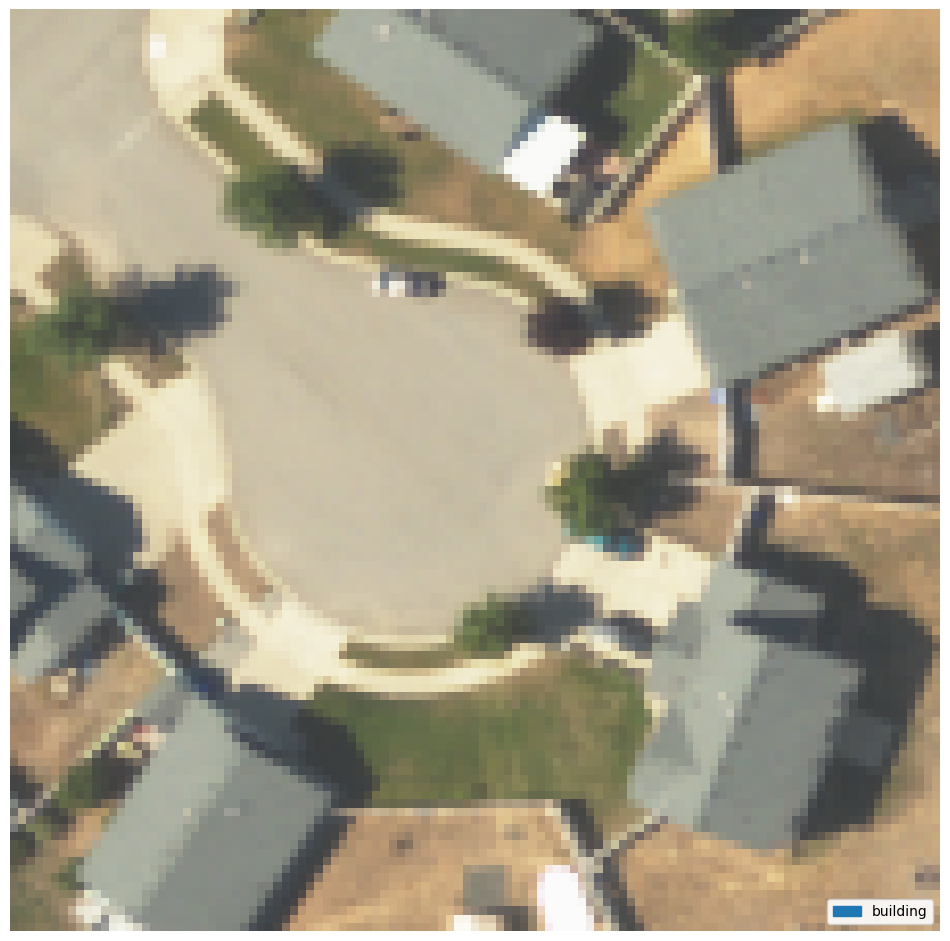

In [25]:
# ...existing code...
# Display segmentation mask overlayed on the NAIP RGB (matplotlib)
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import matplotlib.patches as mpatches
from rasterio.warp import transform_bounds, reproject, Resampling
from rasterio.windows import from_bounds

# Use tif_path and mask_path produced by the segmentation step, if available
tif_path = globals().get("tif_path", "naip_data/m_4711720_sw_11_060_20230701_20230911.tif")
mask_path = globals().get("mask_path", "segmentation_mask.tif")
label_to_value = globals().get("label_to_value", None)  # may exist from segmentation

# function: normalize band -> keep as-is for 8-bit, scale otherwise
def normalize_band(band):
    if np.issubdtype(band.dtype, np.integer) and band.max() <= 255:
        return band.astype(np.uint8)
    band = band.astype("float32")
    if band.ptp() == 0:
        return (band * 0).astype(np.uint8)
    band = (band - band.min()) / band.ptp()
    return (band * 255).astype(np.uint8)

# Helper to get the bbox in raster CRS and a rasterio window, or None if not available/intersect
def get_window_for_bbox(bbox, bbox_crs, src):
    if bbox is None:
        return None, None
    # Normalize bbox ordering (minx, miny, maxx, maxy)
    x1, y1, x2, y2 = bbox
    left, right = min(x1, x2), max(x1, x2)
    bottom, top = min(y1, y2), max(y1, y2)

    # Transform bbox to raster CRS if needed
    if src.crs and src.crs.to_string() != bbox_crs:
        left_t, bottom_t, right_t, top_t = transform_bounds(
            bbox_crs, src.crs, left, bottom, right, top, densify_pts=21
        )
    else:
        left_t, bottom_t, right_t, top_t = left, bottom, right, top

    # Clip bbox to dataset bounds
    src_left, src_bottom, src_right, src_top = src.bounds
    left_clip = max(left_t, src_left)
    right_clip = min(right_t, src_right)
    bottom_clip = max(bottom_t, src_bottom)
    top_clip = min(top_t, src_top)

    if left_clip >= right_clip or bottom_clip >= top_clip:
        # no intersection
        return None, None

    win = from_bounds(left_clip, bottom_clip, right_clip, top_clip, transform=src.transform)
    win = win.round_offsets().round_lengths()
    out_transform = rasterio.windows.transform(win, src.transform)
    return win, out_transform

# Read cropped RGB (if bbox available) or full image
bbox_var = globals().get("bbox", None)
bbox_crs = "EPSG:4326"  # assume leafmap returns lat/lon
with rasterio.open(tif_path) as src:
    print("Raster CRS:", src.crs)
    print("Raster bounds:", src.bounds)
    if bbox_var is not None:
        win, out_transform = get_window_for_bbox(bbox_var, bbox_crs, src)
    else:
        win = None
        out_transform = src.transform

    if win is not None:
        rgb_raw = src.read([1, 2, 3], window=win)
        profile = src.profile.copy()
        profile.update({"height": int(win.height), "width": int(win.width), "transform": out_transform})
    else:
        # bbox not provided or doesn't intersect -> show full raster
        rgb_raw = src.read([1, 2, 3])
        profile = src.profile.copy()
        out_transform = src.transform

# move channels last -> shape (H, W, 3)
rgb = np.moveaxis(rgb_raw, 0, -1)
rgb = np.stack([normalize_band(rgb[..., i]) for i in range(3)], axis=-1)

# Read the mask (crop to the same bbox region), reproject/resample if needed to match RGB
mask = None
try:
    with rasterio.open(mask_path) as msrc:
        # If we have a window from tif, compute a corresponding window on mask (transform bbox)
        if win is not None:
            # Try to reproject/match mask into the same grid as the cropped RGB
            # Read the mask window if mask has same CRS/transform/resolution
            if msrc.crs == src.crs and np.isclose(msrc.transform.a, profile["transform"].a) and np.isclose(
                msrc.transform.e, profile["transform"].e
            ):
                # read directly with same window on mask
                mask = msrc.read(1, window=win)
            else:
                # read the bbox region from mask (transform bbox from bbox_crs -> mask CRS)
                left, bottom, right, top = bbox_var if bbox_var is not None else src.bounds
                if msrc.crs and msrc.crs.to_string() != bbox_crs:
                    left_m, bottom_m, right_m, top_m = transform_bounds(
                        bbox_crs, msrc.crs, left, bottom, right, top, densify_pts=21
                    )
                else:
                    left_m, bottom_m, right_m, top_m = left, bottom, right, top

                win_mask = from_bounds(left_m, bottom_m, right_m, top_m, transform=msrc.transform)
                win_mask = win_mask.round_offsets().round_lengths()
                mask_read = msrc.read(1, window=win_mask)
                # Now reproject the mask_read onto the RGB crop grid (profile transform)
                dst_mask = np.zeros((profile["height"], profile["width"]), dtype=mask_read.dtype)
                reproject(
                    mask_read,
                    dst_mask,
                    src_transform=msrc.window_transform(win_mask),
                    src_crs=msrc.crs,
                    dst_transform=profile["transform"],
                    dst_crs=src.crs,
                    resampling=Resampling.nearest,
                )
                mask = dst_mask
        else:
            # Full mask (no bbox)
            mask = msrc.read(1)
except Exception as e:
    print("Unable to open or crop mask, will display RGB only. Error:", e)
    mask = None

# If mask exists but has different shape than RGB, resample to RGB grid
if mask is not None and (mask.shape[0] != rgb.shape[0] or mask.shape[1] != rgb.shape[1]):
    # Reproject/resample mask to exact rgb shape using rasterio.warp.reproject
    dst_mask = np.zeros((rgb.shape[0], rgb.shape[1]), dtype=mask.dtype)
    # need sources of src_crs/transform from opened mask file; re-open to provide them
    try:
        with rasterio.open(mask_path) as msrc:
            reproject(
                mask,
                dst_mask,
                src_transform=msrc.window_transform(from_bounds(*bbox_var, transform=msrc.transform)) if bbox_var else msrc.transform,
                src_crs=msrc.crs,
                dst_transform=profile["transform"],
                dst_crs=src.crs,
                resampling=Resampling.nearest,
            )
            mask = dst_mask
    except Exception:
        # fallback - simple resize via numpy (nearest)
        mask = np.array(
            np.asarray(
                np.round(
                    np.interp(
                        np.linspace(0, 1, rgb.shape[0]),
                        np.linspace(0, 1, mask.shape[0]),
                        np.arange(mask.shape[0]),
                    )
                ),
                dtype=int,
            )
        )

# Build value->label mapping if label_to_value exists; else use unique values
if label_to_value:
    value_to_label = {v: k for k, v in label_to_value.items()}
else:
    if mask is not None:
        unique_vals = np.unique(mask)
    else:
        unique_vals = np.array([])
    value_to_label = {int(v): str(int(v)) for v in unique_vals if int(v) != 0}

# Determine colors for each label (exclude background 0)
unique_vals = np.unique(mask) if mask is not None else np.array([])
unique_vals = [int(v) for v in unique_vals if int(v) != 0]
cmap = plt.get_cmap("tab20")
colors = {val: (np.array(cmap(i % 20)[:3]) * 255).astype(np.uint8) for i, val in enumerate(unique_vals)}

# Build overlay and alpha map
overlay_rgb = np.zeros_like(rgb, dtype=np.uint8)
alpha = np.zeros((rgb.shape[0], rgb.shape[1]), dtype=np.float32)
if mask is not None:
    for val, color in colors.items():
        mask_idx = mask == val
        overlay_rgb[mask_idx] = color
        alpha[mask_idx] = 0.6  # adjust as needed

# Show figure: cropped base + overlay
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(rgb)
if mask is not None:
    ax.imshow(overlay_rgb, alpha=alpha)
ax.axis("off")

# Legend
patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=value_to_label.get(val, str(val)))
    for val, color in colors.items()
]
if patches:
    ax.legend(handles=patches, loc="lower right", bbox_to_anchor=(1.0, 0.0), framealpha=0.9)
plt.show()
# ...existing code...

In [26]:
# Save a colored RGBA GeoTIFF so you can add it to leafmap and view interactively
import rasterio
import numpy as np
from rasterio.enums import ColorInterp

out_vis_path = 'segmentation_mask_visual.tif'

# Prepare 4-band RGBA (bands, rows, cols)
h, w = mask.shape
rgba = np.zeros((4, h, w), dtype=np.uint8)
rgba[0] = overlay_rgb[..., 0]
rgba[1] = overlay_rgb[..., 1]
rgba[2] = overlay_rgb[..., 2]
rgba[3] = (alpha * 255).astype(np.uint8)

# Use the original tif's profile so geotransform and CRS are preserved
new_profile = profile.copy()
new_profile.update(dtype='uint8', count=4, compress='lzw')

with rasterio.open(out_vis_path, 'w', **new_profile) as dst:
    dst.write(rgba)
    dst.set_band_description(1, 'red')
    dst.set_band_description(2, 'green')
    dst.set_band_description(3, 'blue')
    dst.set_band_description(4, 'alpha')

print('Saved visualization TIFF:', out_vis_path)

# If you already created a leafmap Map 'm' above, add the new file to it
try:
    m.add_raster(out_vis_path, layer_name='Segmentation overlay', opacity=0.7)
    m
except Exception as e:
    print('Leafmap add failed (is m defined?):', e)

# Optionally print mapping legend as plain text
print('\nValue -> Label mapping:')
for val, label in sorted(value_to_label.items()):
    print(f'  {val} -> {label}')

Saved visualization TIFF: segmentation_mask_visual.tif

Value -> Label mapping:
  1 -> building


In [27]:
# Create a NEW map, add the overlay and zoom to the overlay bounds (always create a new map)
import rasterio
from rasterio.warp import transform_bounds
import leafmap

out_vis_path = 'segmentation_mask_visual.tif'


with rasterio.open(out_vis_path) as src:
    b = src.bounds
    crs = src.crs
    # rasterio bounds are (left, bottom, right, top)
    if crs and crs.to_string() != 'EPSG:4326':
        left, bottom, right, top = transform_bounds(crs, 'EPSG:4326', b.left, b.bottom, b.right, b.top, densify_pts=21)
    else:
        left, bottom, right, top = b.left, b.bottom, b.right, b.top

# Always create a new map for the overlay
center_lat = (bottom + top) / 2
center_lon = (left + right) / 2
m_overlay = leafmap.Map(center=[center_lat, center_lon], zoom=16)
m_overlay.add_basemap('Esri.WorldImagery')

# Add the overlay raster and zoom to its bounds
m_overlay.add_raster(out_vis_path, layer_name='Segmentation overlay', opacity=0.7)

try:
    m_overlay.zoom_to_bounds((left, bottom, right, top))
except Exception as e:
    print('Failed to zoom to bounds on new map:', e)

m_overlay


Map(center=[47.651700000000005, -117.595052], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…